<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Ice-age dynamics: 9. Landscape
## Diffusion (weathering, slope wash)
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we model **weathering** and **slope wash**, both regarded as *short-scale processes*,
with a **diffusion equation**.

We first initialize the `python` libraries.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Model

The change in elevation $\frac{\partial h}{\partial t}$ is modelled as diffusion equation, 
thus the change depends on the second spatial derivative of the elevation, $\nabla^2 h$.

$$
\begin{array}{rcl}
  \left( \frac{\partial h}{\partial t} \right)_{diffusion} & = & \kappa_D \nabla^2 h \\
 \kappa_D                                                        & = & u_D h_D
\end{array}
$$

The **diffusivity** $\kappa_D$ controls the diffusion response.

| variable       | name            |unit       |
|----------------|-----------------|-----------|
| $h$            | surface         | [m]       |
| $t$            | time            | [s]       |
| $\nabla$       | Nabla operator  | [1/m]     |
| $\kappa_D$     | Diffusivity     | [m$^2$/s] |
| **Climate**    | -               | -         |
| $h_D$          | soil thickness  | [m]       |
| **Lithology**  | -               | -         |
| $u_D$          | soil velocity   | [m/s]     |

----
## Create grid and initial topography

Make an asymmetrical model with peak height `hmax` over a profile length `length`.

In [11]:
def diffusion_init(nx=101,length=100e3,hmin=0.,hmax=1000.):
    """
    function creates an initial 1D topography
    over profile length
    with hmin and hmax as extreme values
        length [m] default: 100.e3  ! length of profile
        hmin [m]   default: 0.      ! min. topography
        hmax [m]   default: 1000.   ! max. topography
    """
    x    = np.linspace(0,length,nx)
    h = np.zeros(nx)
    h[x <= 0.4*length] = hmin + (hmax-hmin)*x[x <= 0.4*length] / (0.4*length)
    h[x >  0.4*length] = hmin + (hmax-hmin)*(length-x[x >  0.4*length]) / (length-0.4*length)

    tsave = np.zeros(10)
    topo = np.zeros(10*nx).reshape(10,nx)
    tsave[0] = 0.
    topo[0,:] = h
    #print(tsave.shape)
    #print(topo.shape)
    return x,h,tsave,topo,nx,length,hmin,hmax

In [12]:
x,h,tsave,topo,nx,length,hmin,hmax = diffusion_init()

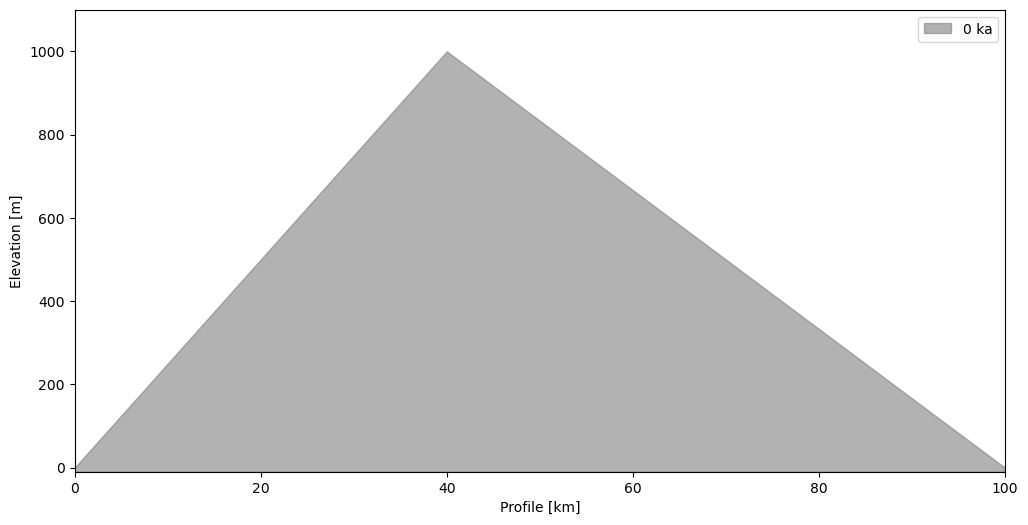

In [13]:
plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
plt.fill_between(x/1000,-10,topo[0,:],color='gray',alpha=0.6,label=str(int(tsave[0]/1000))+' ka')
plt.legend()

----
## Finite differences
Reformulate **partial differential equation** into **finite differences**:

We first need to rewrite the **differential equation** into one dimension ...
$$
\frac{\partial h}{\partial t} = \kappa_D \frac{\partial^2 h}{\partial x^2}
$$
.. then into **finite differences**...
$$
\frac{h(t_i)-h(t_{i-1})}{\Delta t} =  \frac{1}{\Delta x}
\left( \kappa_D \frac{h_{i+1}-h_{i}}{\Delta x} - \kappa_D \frac{h_{i}-h_{i-1}}{\Delta x} \right)
$$
... and finally
$$
h(t_i) = h(t_{i-1}) + \frac{1}{\Delta x}
\left( \kappa_D \frac{h_{i+1}-h_{i}}{\Delta x} - \kappa_D \frac{h_{i}-h_{i-1}}{\Delta x} \right) \Delta t
$$

In [14]:
def diffusion_loop(x,h,tsave,topo,nx,length,hmin,hmax,dtime=1e2,dtsave=1e5,endtime=5e5,uplift=0.,xkd=2e2):
    """
    function applies short-range processes via a 1D diffusion equation
    over a given time window endtime, distretised into dtime intervals
        length [m] default: 100.e3  ! length of profile
        hmin [m]   default: 0.      ! min. topography
        hmax [m]   default: 1000.   ! max. topography
        endtime  = 5.e5            # yr          ! total runtime
        dtime    = 1.e2            # yr          ! time increment
        dtsave   = 1.e5            # yr          ! saving interval

        uplift   = 0.e-3           # m/yr        ! uplift rate
        xkd      = 2.e2            # m^2/yr      ! diffusion constant
    """
    dh = np.zeros(nx)
    dx = x[1] - x[0]
    time = 0.
    save = dtsave
    isave = 0

    while time < endtime:
        # loop over time
        time = time + dtime
        # apply uplift
        h[x <= 0.4*length] = h[x <= 0.4*length] + uplift*dtime*x[x <= 0.4*length] / (0.4*length)
        h[x >  0.4*length] = h[x >  0.4*length] + uplift*dtime*(length-x[x >  0.4*length]) / (length-0.4*length)
        # apply diffusion
        for ij in range(1,nx-1):
            dh[ij] = (((xkd * (h[ij+1]-h[ij]))/dx 
                      -(xkd * (h[ij]-h[ij-1]))/dx ) / dx )*dtime
        h = h + dh
        # save intermediate time step
        if (time==save):
            print(save)
            isave = isave + 1
            topo[isave,:] = h
            tsave[isave]  = time
            save = save + dtsave
    return isave,tsave,topo

----
## No uplift, temporal evolution

In [15]:
x,h,tsave,topo,nx,length,hmin,hmax = diffusion_init()
isave,tsave,topo = diffusion_loop(x,h,tsave,topo,nx,length,hmin,hmax)

100000.0
200000.0
300000.0
400000.0
500000.0


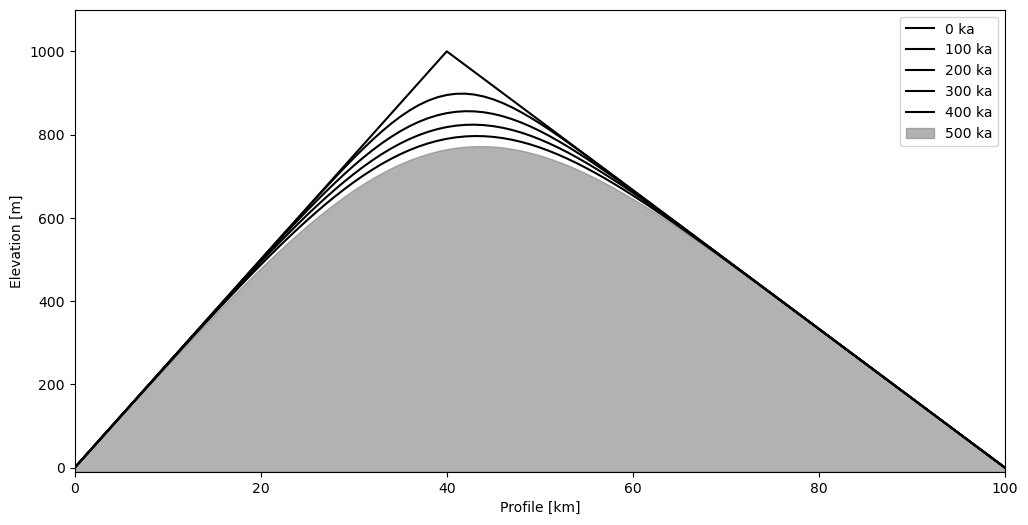

In [16]:
plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
for i in range(isave):
    plt.plot(x/1000,topo[i,:],color='black',linestyle='-',label=str(int(tsave[i]/1000))+' ka')
plt.fill_between(x/1000,-10,topo[isave,:],color='gray',alpha=0.6,label=str(int(tsave[isave]/1000))+' ka')
plt.legend()

----
## Uplift, temporal evolution

100000.0
200000.0
300000.0
400000.0
500000.0


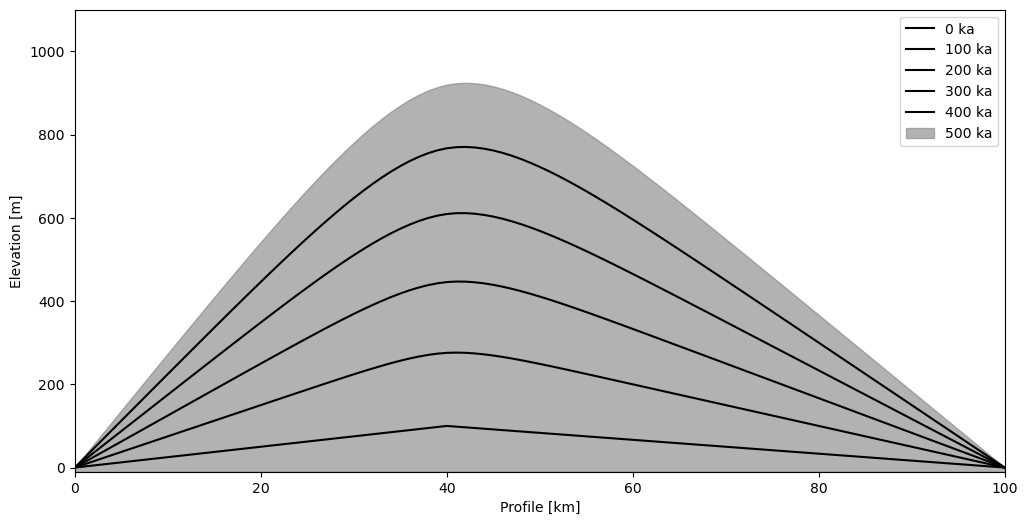

In [17]:
x,h,tsave,topo,nx,length,hmin,hmax = diffusion_init(hmax=100.)
isave,tsave,topo = diffusion_loop(x,h,tsave,topo,nx,length,hmin,hmax,uplift=2e-3)

plt.figure(figsize=(12,6))
plt.xlim([0,length/1000])
plt.ylim([-10,1100])
plt.xlabel('Profile [km]')
plt.ylabel('Elevation [m]')
for i in range(isave):
    plt.plot(x/1000,topo[i,:],color='black',linestyle='-',label=str(int(tsave[i]/1000))+' ka')
plt.fill_between(x/1000,-10,topo[isave,:],color='gray',alpha=0.6,label=str(int(tsave[isave]/1000))+' ka')
plt.legend()

... done